In [24]:
import heapq
import numpy as np
from numba import njit
from numba.typed import List
from seaborn import heatmap
from copy import copy
import matplotlib.pyplot as plt
import pyfmm
from time import time 

    
    


In [25]:
@njit()
def A_STAR_run(grid, p1, p2, dist_cost_map, k_dist_cost,  vis, value, priority_queue, visited, transitions):
    x_max, y_max = grid.shape
    max_dist_cost = np.max(dist_cost_map)

    dxy = [[0,1], [1,0], [-1,0], [0,-1], [1,1], [1,-1], [-1,1], [-1,-1]]
    
    while priority_queue:
        cur_cost, (cur_x, cur_y) = heapq.heappop(priority_queue)
        
        if cur_x == p2[0] and cur_y == p2[1]:
            break
        
        if visited[cur_x, cur_y]:
            continue
        
        for dx, dy in dxy:
            x, y = cur_x + dx, cur_y + dy
            if abs(x)+abs(y)==2: L=np.sqrt(2)
            else: L=1
            if x < 0 or x >= x_max or y < 0 or y >= y_max:
                continue                
            if grid[x,y]: continue
            if ~visited[x,y]:
                if value[cur_x, cur_y] + L < value[x,y]:       
                    
                    value[x,y] = value[cur_x,cur_y] + L 
                    cart_distance = np.sqrt( (p2[0]-x)**2 + (p2[1]-y)**2 ) # activate to get A*
                    dist_cost = distcost(dist_cost_map, max_dist_cost,x,y, p1,vis, k=k_dist_cost) # activate to get smoothed A* 
                    heuristic = value[x,y]  + cart_distance + dist_cost
                    heapq.heappush(priority_queue, (heuristic, (x, y)))
                    transitions[x,y,0] = cur_x
                    transitions[x,y,1] = cur_y

        visited[cur_x,cur_y] = 1
        
    # retrieve the path
    cur_x, cur_y = p2[0], p2[1]
    on_path = []
    on_path.append((cur_x,cur_y))

    while (cur_x, cur_y) != (p1[0], p1[1]):
        cur_x, cur_y = transitions[(cur_x, cur_y)]
        on_path.append((cur_x,cur_y))

    return on_path

@njit()
def A_STAR(grid, dist_cost_map, p1, p2, vis,  k):
    x_max, y_max = grid.shape
    value = np.full_like(grid, 1.0e10)
    value[p1[0],p1[1]] = grid[p1[0],p1[1]]

    if  grid[p1[0],p1[1]] or  grid[p2[0], p2[1]]: raise Exception("Start/goal is not in clear area.")

    visited = np.zeros(grid.shape, dtype=np.bool_)
    transitions = np.zeros((x_max, y_max, 2), dtype=np.int32)
  
    priority_queue = []
    priority_queue.append((0., (p1[0],p1[1])))

    return A_STAR_run(grid, p1, p2, dist_cost_map, k, vis, value, priority_queue, visited, transitions)

@njit()
def distcost(map, max, x, y, p, vis, k=1):

    cost = map[x,y]
    return k*(max - cost)

def get_xy_vision(grid, p, vision):

    xv_min = max(p[0]-vision, 0)
    yv_min = max(p[1]-vision, 0)
    xv_max = min(p[0]+vision, grid.shape[0])
    yv_max = min(p[1]+vision, grid.shape[1])

    return (xv_min, xv_max), (yv_min, yv_max)


In [26]:


path  = 10
orig = np.ones((400,400))

grid = np.zeros_like(orig)
grid[25:45, 10:30] = 1
grid[70:80, 10:30] = 1
grid[25:45, 50:90] = 1
grid[70:80, 60:80] = 1


p1 =np.array([23,20])
p2 = np.array([90,80])

vision = 200



xvis, yvis = get_xy_vision(grid, p1, vision)
print(xvis,yvis)

start = time()
GRIDCOSTMAP1 = np.clip(pyfmm.march(grid== 1, batch_size=10000)[0], a_min=0, a_max=10) #[xvis[0]:xvis[1], yvis[0]:yvis[1]] 
print(time()-start)


start = time()
res = A_STAR(grid, GRIDCOSTMAP1, p1, p2,vision, k=2)
print(time()-start)

#plt.imshow(grid[:,:], interpolation='None')
#plt.colorbar()
#plt.title('Irregular boundary')
#plt.show()
#
#plt.imshow(GRIDCOSTMAP1[:,:], interpolation='None')
#plt.colorbar()
#plt.title('Irregular boundary')
#plt.show()

(0, 223) (0, 220)
0.6009159088134766
1.3295891284942627


In [11]:
#heatmap(orig[:, :])

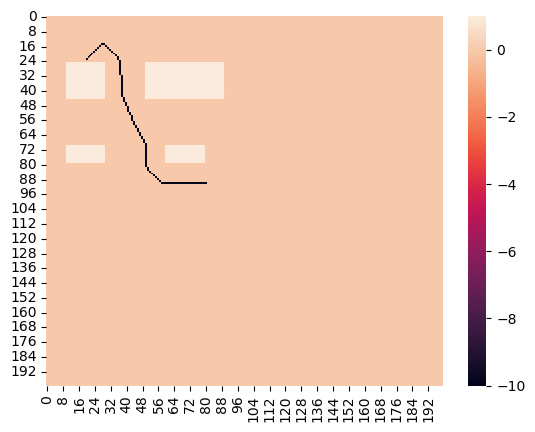

In [27]:
new = copy(grid)
for p in res:
    new[p[0], p[1]] = -path 
heatmap(new[:200, :200])

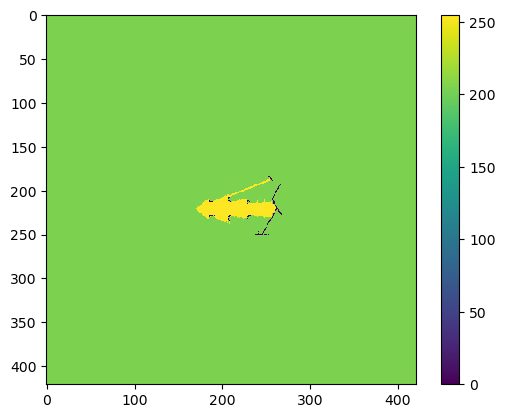

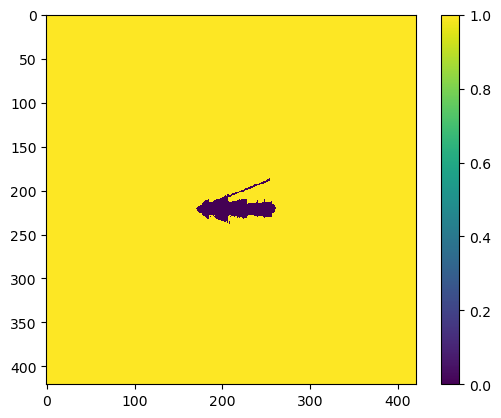

In [28]:

my_img = plt.imread('map.jpg')
plt.imshow(my_img)
plt.colorbar()
plt.show()
my_img = plt.imread('map.jpg')
grid_img = (255 - my_img > 20).astype(int)

plt.imshow(grid_img)
plt.colorbar()
plt.show()



(120, 320) (75, 275)
0.026247024536132812
0.0015761852264404297


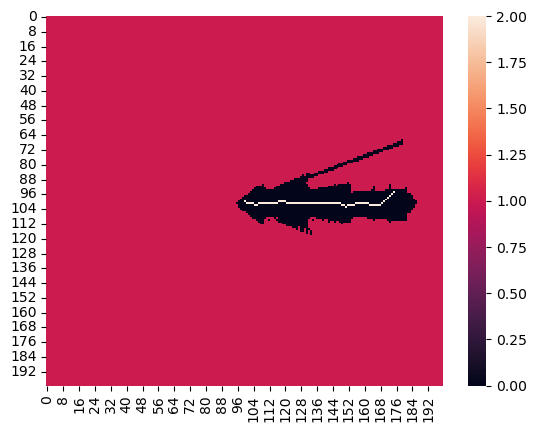

In [35]:
my_img = plt.imread('map.jpg')
grid_img = (255 - my_img > 20).astype(int)

p1 =np.array([220,175])
p2 = np.array([215,250])

vision = 100

xvis, yvis = get_xy_vision(grid_img, p1, vision)
print(xvis, yvis)

start = time()
GRIDCOSTMAP = np.clip(pyfmm.march(grid_img == 1, batch_size=10000)[0], a_min=0, a_max=20) #[xvis[0]:xvis[1], yvis[0]:yvis[1]]
print(time()-start)


start = time()
res = A_STAR(grid_img, GRIDCOSTMAP, p1, p2, vision, k=2)
print(time()-start)

new=copy(grid_img)
for p in res:
    new[p[0], p[1]] = 2
heatmap(new[xvis[0]:xvis[1], yvis[0]:yvis[1]])


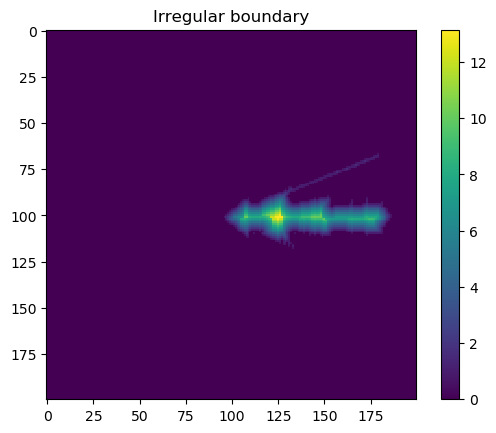

In [32]:
plt.imshow(GRIDCOSTMAP[xvis[0]:xvis[1], yvis[0]:yvis[1]], interpolation='None')
plt.colorbar()
plt.title('Irregular boundary')
plt.show()